# Import Statements

In [6]:
import sys
import re
import matplotlib.pyplot as plt
import numpy as np
import csv

# Files

In [25]:
f = 'probs.csv' # csv file
labels = 'eval_labels.csv' # label file
different = []

# Labels

| Label        | ON           | OFF  |
| ------------- |:-------------:|-----:| 
| 0| narrow diagonal (1) |narrow diagonal (1) |
| 1| narrow diagonal (1+)|narrow diagonal (1+)|
| 2|narrow horizontal|narrow horizontal|
| 3|narrow vertical (1)|narrow vertical (1)|
| 4|narrow vertical (even)|narrow vertical (even)|
| 5|narrow vertical (inf)|narrow vertical (inf)|
| 6|wide diagonal (1)|wide diagonal (1)|
| 7|wide diagonal (1+)|wide diagonal (1+)|
| 8|no_sig|no_sig|
| 9|comb_sig|comb_sig|
| 10| narrow diagonal (1) |other |
| 11| narrow diagonal (1+)|other |
| 12|narrow horizontal|other |
| 13|narrow vertical (1)|other |
| 14|narrow vertical (even)|other |
| 15|narrow vertical (inf)|other |
| 16|wide diagonal (1)|other |
| 17|wide diagonal (1+)|other |
| 18|no_sig|other |
| 19|comb_sig|other |



## Plot a histogram of probabilities of each class

In [28]:
def histoPlot(f):
    """
    f: csv file containing the predicted probabilities of
    each class for all test samples.
    
    returns a histogram of the probabilities.
    """
    with open(f, 'rt') as fi:
        reader = csv.reader(fi)
        data = list(reader)
    fi.close()
    data = np.array([d[1:] for d in data][1:]).astype(np.float)
    data = data.flatten()
    print("max confidence: " + str(np.max(data)))
    print("min confidence: " + str(np.min(data)))

    plt.hist(data, bins = np.linspace(0,1,101))
    plt.title("Histogram of Confidence Probabilities")
    plt.show()


max confidence: 1.0
min confidence: 0.0


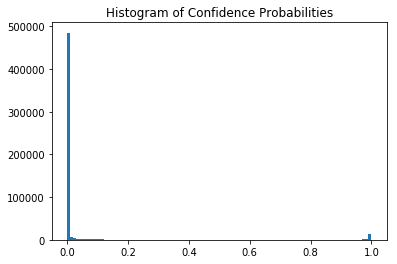

In [29]:
histoPlot(f)

## Plot probabilities of each class for sample x

In [56]:
def randPlot(f, labels, s = -1):
    """
    f: csv file containing the predicted probabilities of
    each class for all test samples.
    labels: csv file containing the actual label of each
    class for all test samples.
    s: optional argument (int) denoting sample number
    
    returns a bar graph of predicted probabilities for each
    class for a random sample, with the correct class 
    highlighted in red.
    """

    header, correct = 0, 0

    fRead = open(f, 'r')
    reader = csv.reader(fRead)
    row_count = sum(1 for row in fRead) - 1
    fRead.close()


    if s == -1 or s > row_count:
        sample = np.random.randint(0, row_count)
    else:
        sample = s
        
    i = 0

    fRead = open(f, 'r')
    reader = csv.reader(fRead)
    for row in reader:
        if i == 0:
            header = row
            i += 1
        elif i == sample + 1:
            vals = row
            break
        else:
            i += 1
    fRead.close()

    labels = open(labels, 'r')
    reader = csv.reader(labels)
    i = 0
    for row in reader:
        if i == sample:
            if row[0][-1] == '0':
                correct = int(row[0][0])
            else:
                correct = int(row[0][0]) * 10 + int(row[0][2])
            break
        else:
            i += 1
    labels.close()
            
    values = [float(v) for v in vals][1:]
    axis = [int(h) for h in header[1:]]
    bars = plt.bar(axis, values)

    max_val, pred = max((v, i) for i, v in enumerate(values))
    plt.xticks(np.arange(0, 20))
    bars[correct].set_color('r')
    
    print("sample number: " + str(sample))
    print("correct: " + str(correct))
    print("predicted: " + str(pred) + " with certainty: " + str(max_val))
    
    plt.title(sample)
    ax = plt.gca()
    ax.set_ylim([0, 1])
    plt.show()


sample number: 16532
correct: 16
predicted: 16 with certainty: 0.77828497


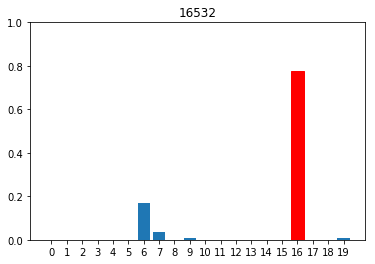

In [58]:
randPlot(f, labels)

## Confusion Matrix of Categorization vs. Actual

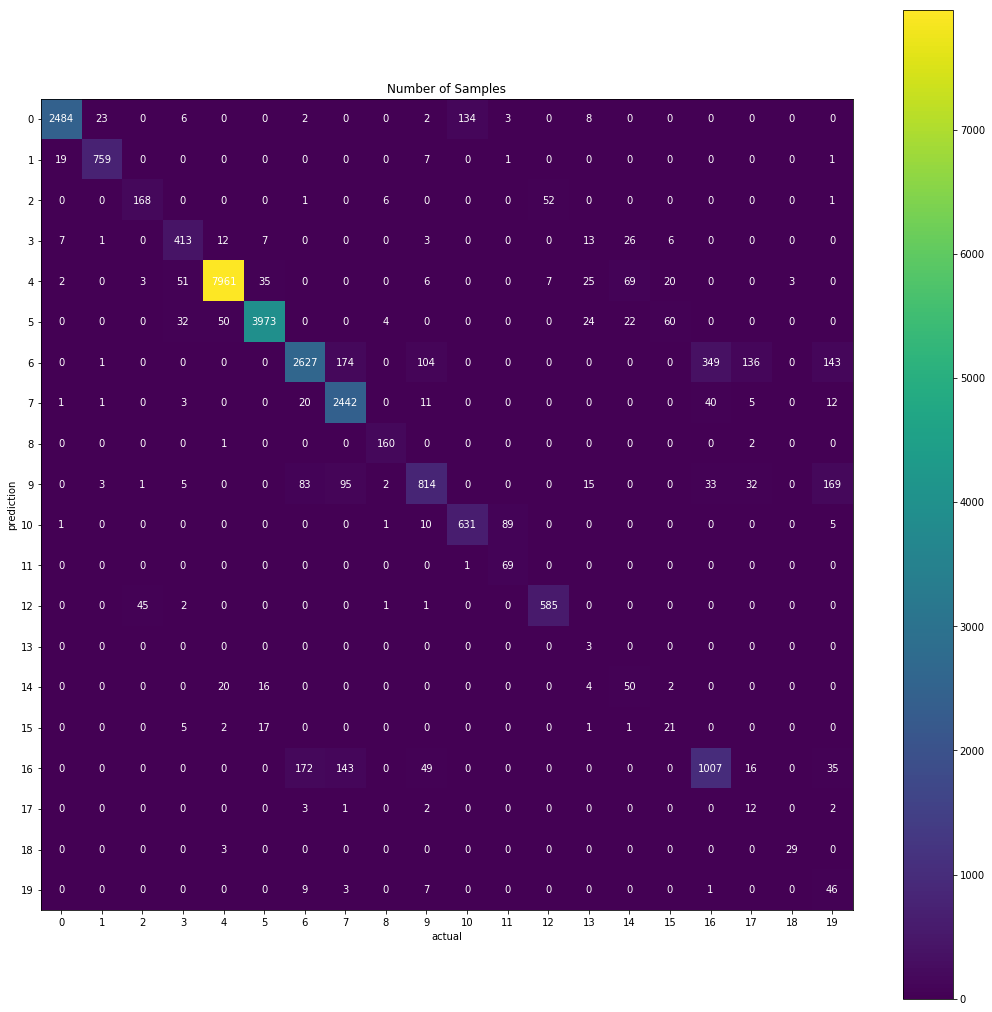

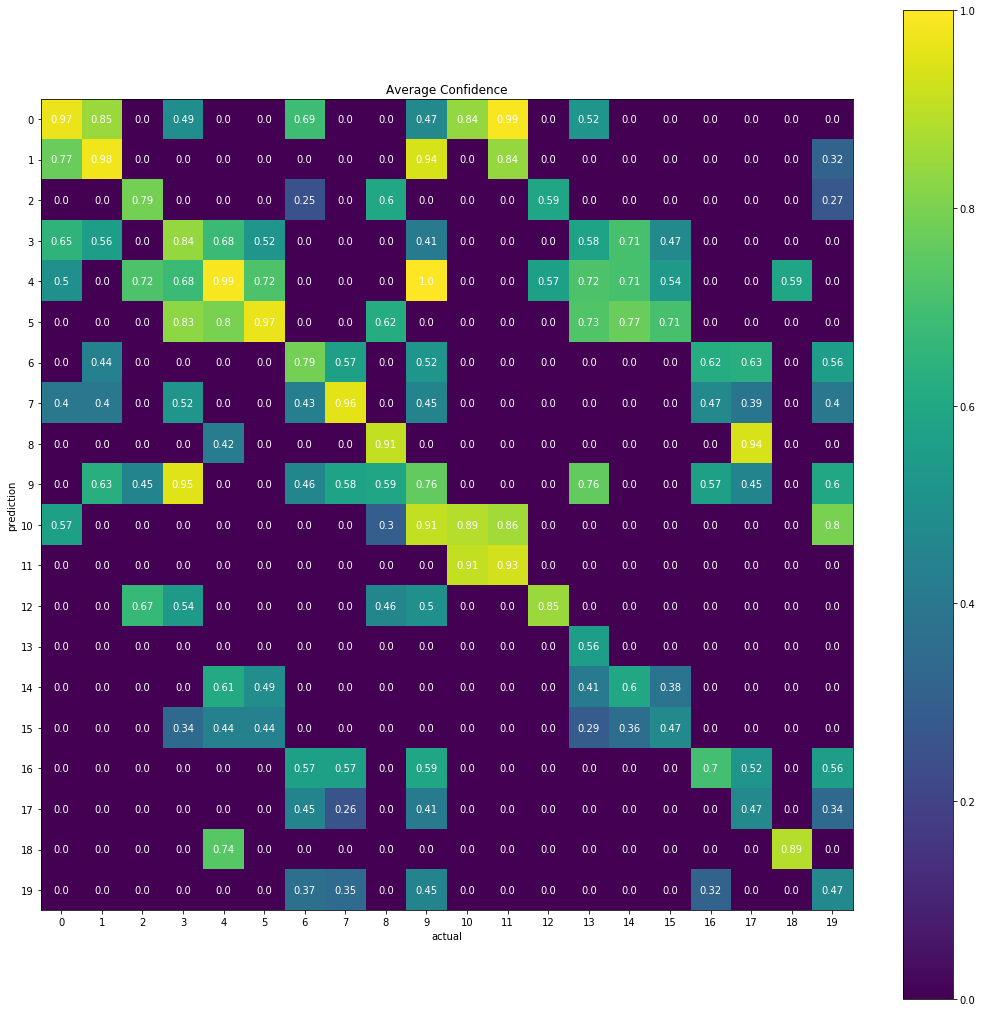

In [146]:
def conf_mat(f, labels):
    """
    f: csv file containing the predicted probabilities of
    each class for all test samples.
    labels: csv file containing the actual label of each
    class for all test samples.
    
    returns 2 confusion matrices comparing  predictions (row) vs actual (col):
        a) number of samples
        b) average confidence
    """
    with open(f, 'rt') as fi:
        reader = csv.reader(fi)
        next(reader) # skip header
        data = list(reader)
    fi.close()
    
    with open(labels, 'rt') as fi:
        reader = csv.reader(fi)
        label = list(reader)
    fi.close()

    conf_arr = np.zeros((20,20),dtype=np.int64)
    conf_arr2 = np.zeros((20,20))

    
    data = [[float(f) for f in d[1:]] for d in data]
    label = [int(float(i)) for l in label for i in l]
    preds = [max((v, i) for i, v in enumerate(values))[1] for values in data]
    conf = [max((v, i) for i, v in enumerate(values))[0] for values in data]
    
    for pred, act, c in zip(preds, label, conf):
        conf_arr[pred][act] += 1
        conf_arr2[pred][act] += c 
    
    for x in range(20):
        for y in range(20):
            if conf_arr2[x][y] > 0:
                conf_arr2[x][y] = round(conf_arr2[x][y] / conf_arr[x][y], 2)
        
    fig = plt.figure(figsize=(40,40))
    plt.clf()
    ax = fig.add_subplot(221)
    ax.set_aspect(1)
    res = ax.imshow(np.array(conf_arr), cmap=plt.cm.viridis, 
                    interpolation='nearest')

    width, height = np.array(conf_arr).shape

    for x in range(width):
        for y in range(height):
            ax.annotate(str(conf_arr[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white')

    cb = fig.colorbar(res)
    plt.xticks(np.arange(0, 20, 1.0))
    plt.yticks(np.arange(0, 20, 1.0))
    plt.xlabel('actual')
    plt.ylabel('prediction')
    plt.title('Number of Samples')

    plt.show()
    
    fig = plt.figure(figsize=(40,40))

    plt.clf()
    ax = fig.add_subplot(221)
    
    ax.set_aspect(1)
    res = ax.imshow(np.array(conf_arr2), cmap=plt.cm.viridis, 
                    interpolation='nearest')

    width, height = np.array(conf_arr2).shape

    for x in range(width):
        for y in range(height):
            ax.annotate(str(conf_arr2[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white')

    cb = fig.colorbar(res)
    plt.xticks(np.arange(0, 20, 1.0))
    plt.yticks(np.arange(0, 20, 1.0))
    plt.xlabel('actual')
    plt.ylabel('prediction')
    plt.title('Average Confidence')

    plt.show()
    
conf_mat(f, labels)